# Only Parallel Data Model

This is the Python Notebook concerning the final version containing the coding for the Only-Parallel (Supervised) version of the program. It is to be completed with the correct format of the Contextual and Style Classifiers in their corresponding parts.

Date of upload: Friday 31th January

Actual Version: 2.1, translation implemented (Monday 10th February)

Precedent Versions : 2.0, 1.1, 1.0



## import(s)

In [19]:
from scripts.data_builders.prepare_dataset import prepare_dataset,string2code,code2string

import math
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device = ",device)

device =  cuda


## Data Pre-processing

In [20]:
train_data, dict_words = prepare_dataset("data/shakespeare.csv",device,ratio=0.5,shuffle_ctx=False) #check with shift+tab to look at the data structure
batch_size = 64
dict_token = {b:a for a,b in dict_words.items()}

Loading ...
- Shakespeare dataset length :  21079
- Corrupted samples (ignored) :  0


## Parameters and Embedding

In [21]:
class State:
    def __init__(self,model,optim):
        self.model = model
        self.optim = optim
        self.epoch = 0
savepath = Path("data/models/embedding_v1")
embedding = torch.load(savepath).to(device)

In [22]:
nb_heads = 4
d_feedforward = 1024
batch_size = 64
dict_size = len(dict_token)

d_embedding = embedding.embedding_dim

## Positional Encoding

In [23]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Context Classifier (To be filled)

In [24]:
savepath_style = Path("data/models/coherence_classifier_v1_epoch_100")
coherence_classifier = torch.load(savepath_style).to(device)
coherence_classifier.requires_grad = False

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Style classifier (To be filled)

In [25]:
savepath_style = Path("data/models/style_classifier_v1")
style_classifier = torch.load(savepath_style).to(device)
style_classifier.requires_grad = False

## Model (To be adapted once we have the Context and Style Class For the Embedding)

In [26]:
class ParallelModel(torch.nn.Module):
    def __init__(self,dict_size, d_embedding, nb_heads, d_feedforward):
        super().__init__()
        
        self.embed_layer = torch.nn.Embedding(dict_size+1, d_embedding, padding_idx=dict_size)
        self.positional_layer = PositionalEncoding(d_embedding)
        self.sentence_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.context_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.sentence_decoder = torch.nn.TransformerDecoderLayer(d_model = d_embedding, nhead = nb_heads, 
                                                    dim_feedforward = d_feedforward)
        self.label_embedding = torch.nn.Embedding(2,768)
    
    
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self,x,ctx_x,y,label_x):
        device = x.device
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
        mask_y = self._generate_square_subsequent_mask(y.shape[1]).to(device)
        
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
        
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
        
        # Encoders
        x_enc = self.sentence_encoder(x,mask_x)
        ctx_enc = self.context_encoder(ctx_x,mask_ctx)

        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1]))
        x_lab = x_and_ctx + self.label_embedding(label)
        
        # Decoder
        y = self.embed_layer(y)
        y_pos = self.positional_layer(y.transpose(0,1))
        y_pred = self.sentence_decoder(y_pos,x_lab,mask_y)
        
        return(y_pred.transpose(0,1),y)
    
    def translator(self,x,ctx_x,y,label_x):
        device = x.device
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
        
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
        
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
        
        # Encoders
        x_enc = self.sentence_encoder(x,mask_x)
        ctx_enc = self.context_encoder(ctx_x,mask_ctx)
        
        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1]))
        x_lab = x_and_ctx + self.label_embedding(label)
        return(x_lab)
            

## Training  (To be adapted once we have the Context and Style Class For the Embedding)

In [27]:
# Definition of the model(s)

model = ParallelModel(dict_size, d_embedding, nb_heads, d_feedforward).to(device)
model.embed_layer = embedding
model.embed_layer.weight.requires_grad = False

In [16]:
# Information concerning the Training optimizer

from torch.optim import Adam

decoder_linear = torch.nn.Linear(d_embedding,dict_size).to(device)
softmax_layer = torch.nn.LogSoftmax(dim = 2).to(device)

params = list(model.parameters()) + list(decoder_linear.parameters())#+ list(context_encoder.parameters()) + 
                                  #list(linear_context.parameters) + list(sentence_decoder.parameters())

l_r = 5e-2
optimizer=Adam(params,lr=l_r)

#Weights of the losses
l1=1 #
l2=1e-2
l3=1

In [17]:
# Losses 
loss_seq2seq = torch.nn.SmoothL1Loss(reduction='mean') #Contextual Seq2Seq Loss

In [40]:
nb_epoch = 1

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True,collate_fn=train_data.collate)
n = len(train_data.x) // batch_size
loss_graph = []
loss_style_list = []
loss_seq_list = []
for epoch in range(nb_epoch):
    total_loss = 0
    total_style = 0
    total_seq = 0
    i = 0
    for x,y, ctx_x, ctx_y_1,ctx_y_2, label_x in train_loader:
        i += 1
        optimizer.zero_grad()
        
        y_pred, y = model.forward(x,ctx_x,y,label_x) #Output still embedded 
        
        # Seq2Seq Loss with Token
        
        loss_seq = l1*loss_seq2seq(y_pred,y)
        
        # Argmax
        y_pred = decoder_linear(y_pred)
        y_pred = torch.argmax(softmax_layer(y_pred),dim = 2)
        print(y_pred)
        print(y_pred.shape)
        # Style class
        loss_sty,style_pred = style_classifier.forward(inputs_embeds=y_pred,)
        loss_sty = l2*loss_sty
        
        # Coherence class
        #loss_coh,coh_pred = coherence_classifier()
        #loss_sty = l2*loss_sty
        
        # Step
        
        loss = loss_seq + loss_sty # + loss_coh
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_style += loss_sty.item()
        total_seq += loss_seq.item()
        if(i == 1 or i%5 == 0 or i == n):
          print('| epoch {:3d} | {:5d}/{:5d} batches | '
                'loss {:5.2f} | loss_seq  {:5.2f} | loss_style {:5.2f} | '
                'total loss {:5.2f} | l_rate {:.0e}'.format(
                  epoch+1, i, n+1,loss.item(),loss_seq.item(),loss_sty.item(),
                    total_loss/i,optimizer.param_groups[0]["lr"]))
        loss_graph += [total_loss/i]
        loss_style_list += [total_style/i]
        loss_seq_list += [total_seq/i]
    print('-' * 70)
    print("Epoch ",epoch+1,"\t",round(total_loss / n,2))
    print('-' * 70)

tensor([[ 2197,  7850,  3303,  ...,  4679,  4679,  4679],
        [ 6667,  3303,  2566,  ...,  7850,  4679,  4679],
        [ 7411, 15929,  4216,  ...,  8991,  4679,  4679],
        ...,
        [ 5962, 11337,  1166,  ..., 12458,  4679,  4679],
        [ 2826,  2397,  3846,  ...,  4249,  7850,  4679],
        [ 7411,  8405, 14557,  ...,  8991,  4679,  8991]], device='cuda:0')
torch.Size([64, 51])


ValueError: not enough values to unpack (expected 3, got 2)

In [41]:
dict_token[4679]

'CHALLENGES'

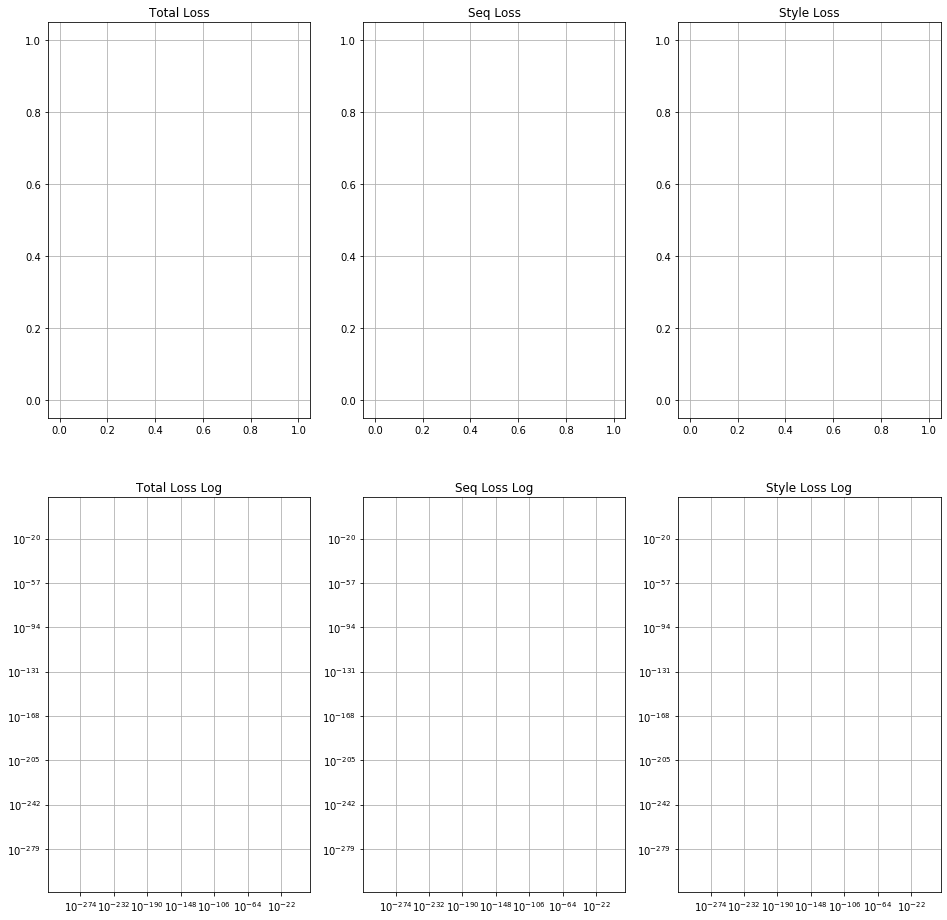

In [39]:
# reduction = 'sum' l_r = 5e-4
from matplotlib import pyplot as plt
import numpy as np
rango = np.arange(len(loss_graph))
plt.figure(1,figsize=(16,16))
plt.subplot(231)
plt.plot(rango,loss_graph)
plt.title("Total Loss")
plt.grid()
plt.subplot(234)
plt.plot(rango,loss_graph)
plt.xscale('log')
plt.yscale('log')
plt.title("Total Loss Log")
plt.grid()
plt.subplot(232)
plt.plot(rango,loss_seq_list)
plt.title("Seq Loss")
plt.grid()
plt.subplot(235)
plt.plot(rango,loss_seq_list)
plt.xscale('log')
plt.yscale('log')
plt.title("Seq Loss Log")
plt.grid()
plt.subplot(233)
plt.plot(rango,loss_style_list)
plt.title("Style Loss")
plt.grid()
plt.subplot(236)
plt.plot(rango,loss_style_list)
plt.title("Style Loss Log")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [50]:
x,y,ctx_x,_,_,_,_,_,label_x,_ = train_data[0]
print("Original Phrase",code2string(x,dict_token))
print("Target phrase",code2string(y,dict_token))
if(label_x.item() == 1):
    print("Original Style : Shakespearian")
else:
    print("Original Style : Modern")
x.unsqueeze(0).shape

Original Phrase I HAVE A MIND TO STRIKE THEE ERE
Target phrase I HAVE HALF A MIND TO HIT YOU BEFORE YOU SPEAK
Original Style : Shakespearian


torch.Size([1, 13])

In [116]:
    #Generation de phrase 
with torch.no_grad():
        h_t = model.translator(x.unsqueeze(0),ctx_x.unsqueeze(0),y.unsqueeze(0),label_x.unsqueeze(0))
        phrase = torch.tensor([[0]])
        print("Starting with: ",end='')
        for p in phrase:
            print(dict_token[p.item()],end=' ')
        print("")
        i = 0
        limit = 20
        flag = False
        while(not(flag) and i != limit):
            #mask = model._generate_square_subsequent_mask(phrase.shape[1])
            y_aux = model.embed_layer(phrase)
            y_pos = model.positional_layer(y_aux)
            y_pred = model.sentence_decoder(y_pos,h_t).transpose(0,1)
            y_pred = decoder_linear(y_pred)
            y_pred = torch.argmax(softmax_layer(y_pred),dim = 2)
            phrase = torch.cat((phrase,y_pred[:,-1].reshape((1,1))),0)
            i += 1
        print("Produced phrase: ",end='')
        for p in phrase:
            print(dict_token[p.item()],end=' ')
        print("")
            

Starting with: <SOS> 
torch.Size([1, 1])
tensor([15183])
Produced phrase: <SOS> AMPLE 
torch.Size([1, 2])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE 
torch.Size([1, 3])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE AMPLE 
torch.Size([1, 4])
tensor([15241])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY 
torch.Size([1, 5])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE 
torch.Size([1, 6])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE 
torch.Size([1, 7])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE 
torch.Size([1, 8])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE 
torch.Size([1, 9])
tensor([15241])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE BERKELEY 
torch.Size([1, 10])
tensor([64])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE BERKELEY THAN 
torch.Size([1, 11])
tensor([10566]